In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('bmh')

In [68]:
import torch

from itertools import permutations
from collections import defaultdict
from tqdm import tqdm_notebook

from sent_order.models.kt_regression import Corpus

In [ ]:
sent_encoder = torch.load(
    '../../data/models/new/ctx-reg/sent_encoder.999.bin',
    map_location={'cuda:0': 'cpu'},
)

In [5]:
graf_encoder = torch.load(
    '../../data/models/new/ctx-reg/graf_encoder.999.bin',
    map_location={'cuda:0': 'cpu'},
)

In [6]:
regressor = torch.load(
    '../../data/models/new/ctx-reg/regressor.999.bin',
    map_location={'cuda:0': 'cpu'},
)

In [9]:
dev = Corpus('../../data/dev.json/', 10000)

100%|██████████| 10000/10000 [00:01<00:00, 7200.97it/s]


In [76]:
grafs = [g for g in dev.grafs if len(g.sentences) == 5]

In [77]:
len(grafs)

1647

In [246]:
graf = grafs[610]

In [247]:
[' '.join(s.tokens) for s in graf.sentences]

['We study the contribution to the entanglement entropy of ( 2 + 1)-dimensional conformal field theories coming from a sharp corner in the entangling surface .',
 'This contribution is encoded in a function $ a(\\theta)$ of the corner opening angle , and was recently proposed as a measure of the degrees of freedom in the underlying CFT .',
 'We show that the ratio $ a(\\theta)/C_T$ , where $ C_T$ is the central charge in the stress tensor correlator , is an almost universal quantity for a broad class of theories including various higher - curvature holographic models , free scalars and fermions , and Wilson - Fisher fixed points of the $ O(N)$ models with $ N=1,2,3$.',
 'Strikingly , the agreement between these different theories becomes exact in the limit $ \\theta\\rightarrow \\pi$ , where the entangling surface approaches a smooth curve .',
 'We thus conjecture that the corresponding ratio is universal for general CFTs in three dimensions .']

In [248]:
sents = sent_encoder(graf.sentence_variables(), 30)

In [249]:
def predict(sents, perm):
    
    sents = sents[torch.LongTensor(perm)]
    
    graf = graf_encoder([sents], 30)
    
    x = torch.stack([
        torch.cat([graf[0], sent])
        for sent in sents
    ])
    
    return regressor(x)

In [250]:
perms = list(permutations(range(len(sents))))

In [251]:
preds = defaultdict(list)

for perm in tqdm_notebook(perms):
    for pos, val in zip(perm, predict(sents, perm)):
        preds[pos].append(val.data[0])

HBox(children=(IntProgress(value=0, max=120), HTML(value='')))

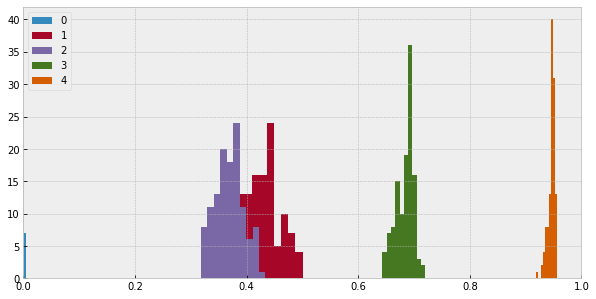

In [252]:
plt.figure(figsize=(10, 5))
plt.xlim(0, 1)
plt.set_cmap('binary')

for i in range(len(preds)):
    plt.hist(preds[i], label=str(i))
    
plt.legend()